In [2]:
# 라이브러리 로드
import os
import json
import csv
import requests
import folium
import pandas as pd
import numpy as np
import platform
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import re

In [90]:
s_data = pd.read_csv('catcat2.csv')
s_data.head()

,Unnamed: 0,Name,Rating,Review,Description,Price_Range,Label,Category,Location,Location_1,Category_1
0,0,런던 베이글 뮤지엄 도산,4.4,3419,"방금 나온 베이글, 따뜻한 수프가 기다리는 가장 가까운 런던 속 베이글 뮤지엄",점심 저녁 동일가 1 - 2만원,웨이팅,"카페,디저트",도산공원,강남구,카페
1,1,산청숯불가든 마곡,4.6,583,"산청흑돼지, 전통 숯가마, 산지 식재료로 우리만의 맛을 담은 고깃집* 원격 웨이팅이...",점심 저녁 동일가 2 - 6만원,웨이팅,돼지고기구이,마곡,강서구,한식
2,2,라프레플루트,4.3,278,다양한 과일을 쉽고 간편하게 접할 수 있는 프리미엄 과일가게,점심 저녁 동일가 1 - 3만원,웨이팅,"카페,디저트",서울숲,성동구,카페
3,3,한소반 청계산점,4.3,197,보쌈으로 유명한 청계산 맛집,점심 저녁 동일가 1 - 2만원,웨이팅,"육류,고기요리",청계산,서초구,한식
4,4,크레이지카츠,4.7,562,육즙이 살아있는 두툼한 일식 돈카츠,점심 저녁 동일가 1 - 2만원,웨이팅,돈가스,합정,마포구,한식


In [113]:
# 가격 전처리
s_data = pd.read_csv('catcat2.csv')
s_data.head()


def split_launch(x):
    if '동일가' in x:
        return x[-8:].strip()  
    elif '점심 영업안함' in x:
        return '영업안함'
    elif '점심' in x and '가격변동' in x:
        return '가격변동'
    else:
        return x[:12].strip()
s_data['점심'] = s_data['Price_Range'].apply(split_launch)


def split_dinner(x):
    if '저녁' in x and '동일가' in x:
        return x[-8:].strip()  
    elif '점심' in x and '영업안함' in x:
        return x[-11:].strip()
    elif '저녁 영업안함' in x:
        return '영업안함'
    else:
        return x[-12:].strip()
s_data['저녁'] = s_data['Price_Range'].apply(split_dinner)




# 키워드를 써서 남은 것 전처리
def remove_keywords(value):
    keywords = ['점심', '저녁', '·', '만원', '동일가', '런치', '미만', '자', '일가', '디너', '오마카세', '주말']
    for keyword in keywords:
        value = value.replace(keyword, '').strip()
    return value

# 'Price_Range' 열의 각 값에 대해 키워드 제거 함수 적용
s_data['점심'] = s_data['점심'].apply(remove_keywords)
s_data['저녁'] = s_data['저녁'].apply(remove_keywords)


def extract_avg(column):
    # 영업안함 또는 가격변동이 포함되어 있는지 체크하는 함수
    def check_pattern(text):
        if '영업안함' in text:
            return '영업안함'
        elif '가격변동' in text:
            return '가격변동'
        else:
            return text
    
    # 점심 또는 저녁 컬럼에 대해 check_pattern 함수를 적용하여 결과 반환
    return column.apply(lambda x: check_pattern(x) if isinstance(x, str) else x)

# 'avg_점심' 컬럼 생성
s_data['avg_점심'] = extract_avg(s_data['점심'])

# 'avg_저녁' 컬럼 생성
s_data['avg_저녁'] = extract_avg(s_data['저녁'])




def convert_price(price):
    # 천원 단위를 변환
    price = re.sub(r'(\d+)천원', lambda x: f"0.{x.group(1)}", price)
    # 만원과 천원이 같이 있는 경우 변환
    price = re.sub(r'(\d+)만\s+(\d+)천원', lambda x: f"{x.group(1)}.{x.group(2)}", price)
    # 만원 단위를 변환
    price = re.sub(r'(\d+)만원', lambda x: f"{x.group(1)}", price)

    return price

# 가격 변환 및 추출
s_data['점심'] = s_data['점심'].apply(convert_price)
s_data['저녁'] = s_data['저녁'].apply(convert_price)




def merge_price_ranges(price):
    # 숫자(소수 포함)를 추출하는 정규 표현식
    pattern = r'\d+(?:\.\d+)?'
    numbers = re.findall(pattern, price)
    
    # 숫자 리스트가 비어있지 않은 경우 최소값과 최대값 찾기
    if numbers:
        numbers = list(map(float, numbers))
        min_value = min(numbers)
        max_value = max(numbers)
        return pd.Series({'min': min_value*10000, 'max': max_value*10000})
    else:
        return pd.Series({'min': None, 'max': None})



# 'min'과 'max' 컬럼 , avg 추가
s_data[['min_점심', 'max_점심']] = s_data['점심'].apply(merge_price_ranges)
s_data['avg_점심'] = s_data[['min_점심', 'max_점심']].mean(axis=1)

s_data[['min_저녁', 'max_저녁']] = s_data['저녁'].apply(merge_price_ranges)
s_data['avg_저녁'] = s_data[['min_저녁', 'max_저녁']].mean(axis=1)


# 빈칸에 영업 안함이나 가격변동 원하지 않으면 이 코드를 주석처리하고 다시 돌려주세요
# 'avg_점심' 값 설정
s_data['avg_점심'] = s_data.apply(lambda row: row['점심'] if not row['avg_점심'] else 
                                  ('가격변동' if '가격변동' in row['점심'] or '가격 변동' in row['점심'] else 
                                   ('영업안함' if '영업안함' in row['점심'] or '영업 안함' in row['점심'] else row['avg_점심'])), axis=1)

# 'avg_저녁' 값 설정
s_data['avg_저녁'] = s_data.apply(lambda row: row['저녁'] if not row['avg_저녁'] else 
                                  ('가격변동' if '가격변동' in row['저녁'] or '가격 변동' in row['저녁'] else 
                                   ('영업안함' if '영업안함' in row['저녁'] or '영업 안함' in row['저녁'] else row['avg_저녁'])), axis=1)






# def reshape(price):
#     # 숫자만 추출하여 리스트로 반환
#     numbers = re.findall(r'\d+(?:\.\d+)?', price)
#     if numbers:
#         # 숫자가 있는 경우, 숫자만 반환
#         return ' '.join(numbers)
#     else:
#         # 숫자가 없는 경우, 원래 문자열 반환
#         return price



# # '점심'과 '저녁' 열에 reshape 함수 적용
# s_data['점심'] = s_data['점심'].apply(reshape)
# s_data['저녁'] = s_data['저녁'].apply(reshape)

# 테스트 컬럼 제거
s_data.drop(['점심', '저녁'], axis=1, inplace=True)

s_data.head()
# Excel 파일 저장
s_data.to_excel('a.xlsx', index=False)

# CSV 파일 저장
s_data.to_csv('a.csv', index=False)

In [115]:
df = pd.read_csv('a.csv')
df

,Unnamed: 0,Name,Rating,Review,Description,Price_Range,Label,Category,Location,Location_1,Category_1,avg_점심,avg_저녁,min_점심,max_점심,min_저녁,max_저녁
0,0,런던 베이글 뮤지엄 도산,4.4,3419,"방금 나온 베이글, 따뜻한 수프가 기다리는 가장 가까운 런던 속 베이글 뮤지엄",점심 저녁 동일가 1 - 2만원,웨이팅,"카페,디저트",도산공원,강남구,카페,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0
1,1,산청숯불가든 마곡,4.6,583,"산청흑돼지, 전통 숯가마, 산지 식재료로 우리만의 맛을 담은 고깃집* 원격 웨이팅이...",점심 저녁 동일가 2 - 6만원,웨이팅,돼지고기구이,마곡,강서구,한식,40000.0,40000.0,20000.0,60000.0,20000.0,60000.0
2,2,라프레플루트,4.3,278,다양한 과일을 쉽고 간편하게 접할 수 있는 프리미엄 과일가게,점심 저녁 동일가 1 - 3만원,웨이팅,"카페,디저트",서울숲,성동구,카페,20000.0,20000.0,10000.0,30000.0,10000.0,30000.0
3,3,한소반 청계산점,4.3,197,보쌈으로 유명한 청계산 맛집,점심 저녁 동일가 1 - 2만원,웨이팅,"육류,고기요리",청계산,서초구,한식,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0
4,4,크레이지카츠,4.7,562,육즙이 살아있는 두툼한 일식 돈카츠,점심 저녁 동일가 1 - 2만원,웨이팅,돈가스,합정,마포구,한식,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,3397,돈구멍 마곡본점,5.0,41,창가뷰가 아름다운 저녁노을 맛집 겉바속촉 문어발 솥뚜껑 삽겹살,점심 저녁 동일가 3 - 4만원,예약-웨이팅,돼지고기구이,마곡,강서구,한식,35000.0,35000.0,30000.0,40000.0,30000.0,40000.0
3398,3398,하이디라오 서초점,4.7,894,"중국 본토의 맛 그대로, 차원이 다른 No.1 훠궈",점심 저녁 동일가 3 - 5만원,예약-웨이팅,중식,강남,강남구,중식,40000.0,40000.0,30000.0,50000.0,30000.0,50000.0
3399,3399,하이디라오 영등포점,4.7,950,"중국 본토의 맛 그대로, 차원이 다른 No.1 훠궈",점심 저녁 동일가 3 - 5만원,예약-웨이팅,중식,영등포,영등포구,중식,40000.0,40000.0,30000.0,50000.0,30000.0,50000.0
3400,3400,라이언하트,4.8,111,기분 좋게 한잔 할 수 있는 공간. 아메리칸 다이닝도 함께 즐기실 수 있어요,점심 영업안함 · 저녁 4 - 6만원,예약-웨이팅,"칵테일,위스키",송파,송파구,주류,영업안함,50000.0,NaN,NaN,40000.0,60000.0


In [2]:
s_data = pd.read_csv('catch_update.csv')
s_data.head()

,Unnamed: 0,Name,Rating,Review,Description,Price_Range,Label,Category,Location,Location_1,Category_1,avg_점심,avg_저녁,min_점심,max_점심,min_저녁,max_저녁
0,0,런던 베이글 뮤지엄 도산,4.4,3419,"방금 나온 베이글, 따뜻한 수프가 기다리는 가장 가까운 런던 속 베이글 뮤지엄",점심 저녁 동일가 1 - 2만원,웨이팅,"카페,디저트",도산공원,강남구,카페,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0
1,1,산청숯불가든 마곡,4.6,583,"산청흑돼지, 전통 숯가마, 산지 식재료로 우리만의 맛을 담은 고깃집* 원격 웨이팅이...",점심 저녁 동일가 2 - 6만원,웨이팅,돼지고기구이,마곡,강서구,한식,40000.0,40000.0,20000.0,60000.0,20000.0,60000.0
2,2,라프레플루트,4.3,278,다양한 과일을 쉽고 간편하게 접할 수 있는 프리미엄 과일가게,점심 저녁 동일가 1 - 3만원,웨이팅,"카페,디저트",서울숲,성동구,카페,20000.0,20000.0,10000.0,30000.0,10000.0,30000.0
3,3,한소반 청계산점,4.3,197,보쌈으로 유명한 청계산 맛집,점심 저녁 동일가 1 - 2만원,웨이팅,"육류,고기요리",청계산,서초구,한식,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0
4,4,크레이지카츠,4.7,562,육즙이 살아있는 두툼한 일식 돈카츠,점심 저녁 동일가 1 - 2만원,웨이팅,돈가스,합정,마포구,한식,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0


In [33]:
section_count = s_data.Location_1.value_counts()
# print(section_count)
location = s_data.copy()
# 필요한 컬럼 발췌
location = location[['Name', 'Location_1']]
# section_count = s_data.groupby('Location_1').reset_index(name='음식점 수')
# location
section_count = s_data.groupby('Location_1').size().reset_index(name='음식점 수')
# section_count

seoul_data_loc = section_count.set_index('Location_1').rename_axis('지역구')
seoul_data_loc.sort_values('음식점 수', ascending=False)
# print(seoul_data_loc)

,음식점 수
지역구,
강남구,790
마포구,426
용산구,376
성동구,290
종로구,251
송파구,227
중구,193
영등포구,179
서초구,163


In [35]:
s_data = pd.read_csv('catch_loc_updated_0630.csv')

In [37]:
import pandas as pd
import folium
from folium.features import DivIcon
import requests
import json
from IPython.display import display

# 필요한 데이터 준비
location = s_data.copy()
location = location[['Name', 'Location_1']]
section_count = location.groupby('Location_1').size().reset_index(name='음식점 수')

# 데이터 프레임 설정
seoul_data_loc = section_count.set_index('Location_1').rename_axis('지역구')
seoul_data_loc = seoul_data_loc.sort_values('음식점 수', ascending=False)

# 서울 행정구역 JSON 데이터 로드
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)

# 지도 생성
m = folium.Map(
    location=[37.541, 126.986],
    zoom_start=11,
    tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
    attr='&copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors'
)

# GeoJSON 데이터 추가
folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)

# Choropleth 추가
folium.Choropleth(
    geo_data=seoul_geo,
    data=section_count,  # 전체 DataFrame을 사용
    columns=['Location_1', '음식점 수'],  # 사용할 열을 지정
    key_on='feature.properties.name', 
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2, 
    legend_name='지역구별 음식점 수'
).add_to(m)

# 서울 25개 구의 위도와 경도 데이터 (조정된 값)
seoul_locs = {
    '강남구': [37.5170, 127.0160],
    '강동구': [37.5605, 127.1159],
    '강북구': [37.6400, 126.9750],
    '강서구': [37.5700, 126.8000],
    '관악구': [37.4790, 126.9220],
    '광진구': [37.5385, 127.0525],
    '구로구': [37.4950, 126.8275],
    '금천구': [37.4665, 126.8760],
    '노원구': [37.6545, 127.0565],
    '도봉구': [37.6659, 127.0020],
    '동대문구': [37.5844, 127.0296],
    '동작구': [37.5124, 126.9398],
    '마포구': [37.5641, 126.8818],
    '서대문구': [37.5830, 126.8957],
    '서초구': [37.4564, 127.0376],
    '성동구': [37.5533, 127.0163],
    '성북구': [37.6094, 127.0068],
    '송파구': [37.5145, 127.0756],
    '양천구': [37.5267, 126.8266],
    '영등포구': [37.5265, 126.8865],
    '용산구': [37.5411, 126.9411],
    '은평구': [37.6176, 126.8927],
    '종로구': [37.6031, 126.9492],
    '중구': [37.5637, 126.9676],
    '중랑구': [37.6063, 127.0726]
}

# 각 구에 음식점 수 표시
for gu, coords in seoul_locs.items():
    folium.map.Marker(
        location=coords,
        icon=DivIcon(
            icon_size=(0, 0),
            icon_anchor=(0, 0),
            html=f'''
                <div style="
                    font-size: 0.8rem;
                    color: black;
                    background-color:rgba(255, 255, 255, 0.7);
                    width:100px;
                    text-align:center;
                    margin:0px;
                    padding:2px;
                    border-radius: 5px;
                ">
                    <b>{gu}</b><br/>
                    음식점 수: {seoul_data_loc.loc[gu, '음식점 수']}
                </div>
            '''
        )
    ).add_to(m)

# 지도 표시
display(m)


In [24]:

# 현재 작업 디렉토리 경로 얻기
current_directory = os.getcwd()
# 나눔바른고딕 글꼴 파일 경로 지정
font_path = os.path.join(current_directory, "NanumBarunGothic.ttf")

# 글꼴이 있는지 확인
if os.path.exists(font_path):
    # 폰트 추가
    fm.fontManager.addfont(font_path)

    # 캐시를 새로 고치지 않고 직접 폰트 설정
    font_prop = fm.FontProperties(fname=font_path)
    plt.rc("font", family=font_prop.get_name())
    plt.rcParams["axes.unicode_minus"] = False  # 마이너스 부호 출력 설정

In [25]:
s_data = pd.read_csv('catch_loc_updated_0630.csv')
s_data.head()

,Unnamed: 0,Name,Category,Category_1,Location,Location_1,Label,Rating,Review,avg_lunch,avg_dinner,min_lunch,max_lunch,min_dinner,max_dinner,Location_2
0,0,런던 베이글 뮤지엄 도산,"카페,디저트",카페,도산공원,강남구,웨이팅,4.4,3419,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,도산공원
1,1,산청숯불가든 마곡,돼지고기구이,한식,마곡,강서구,웨이팅,4.6,583,40000.0,40000.0,20000.0,60000.0,20000.0,60000.0,마곡
2,2,라프레플루트,"카페,디저트",카페,서울숲,성동구,웨이팅,4.3,278,20000.0,20000.0,10000.0,30000.0,10000.0,30000.0,서울숲
3,3,한소반 청계산점,"육류,고기요리",한식,청계산,서초구,웨이팅,4.3,197,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,청계산
4,4,크레이지카츠,돈가스,한식,합정,마포구,웨이팅,4.7,562,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,합정


In [8]:
# 지역별 인기 식당
popular_by_location = s_data.groupby('Location_1').apply(lambda x: x.nlargest(1, 'Rating'))
popular_by_location[['Name', 'Location_1', 'Rating']]

C:\Users\RYS\AppData\Local\Temp\ipykernel_45152\896951067.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  popular_by_location = s_data.groupby('Location_1').apply(lambda x: x.nlargest(1, 'Rating'))


,,Name,Location_1,Rating
Location_1,,,,
강남구,300,정돈 신사점,강남구,5.0
강동구,1037,파르삐떼 디저트바,강동구,5.0
강북구,1585,낮달초밥 사시미 수유점,강북구,5.0
강서구,180,돈구멍 마곡본점,강서구,5.0
관악구,220,동백카츠 샤로수길점,관악구,5.0
광진구,237,투또톤토,광진구,5.0
구로구,2220,서울안심축산 신도림역 음식문화의거리점,구로구,5.0
금천구,980,식당오늘,금천구,5.0
노원구,436,유키가츠&텐동 노원점,노원구,5.0


   Location_1  4.5점 식당 개수
0         강남구         609
1         강동구          22
2         강북구           6
3         강서구          80
4         관악구          38
5         광진구          53
6         구로구          17
7         금천구           8
8         노원구          19
9         도봉구           5
10       동대문구          24
11        동작구          40
12        마포구         344
13       서대문구          29
14        서초구         118
15        성동구         230
16        성북구          36
17        송파구         163
18        양천구          16
19       영등포구         126
20        용산구         289
21        은평구          18
22        종로구         163
23         중구         135
24        중랑구          11


C:\Users\RYS\AppData\Local\Temp\ipykernel_45152\1629537622.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rate45_location, x='Location_1', y='4.5점 식당 개수', palette='cool')


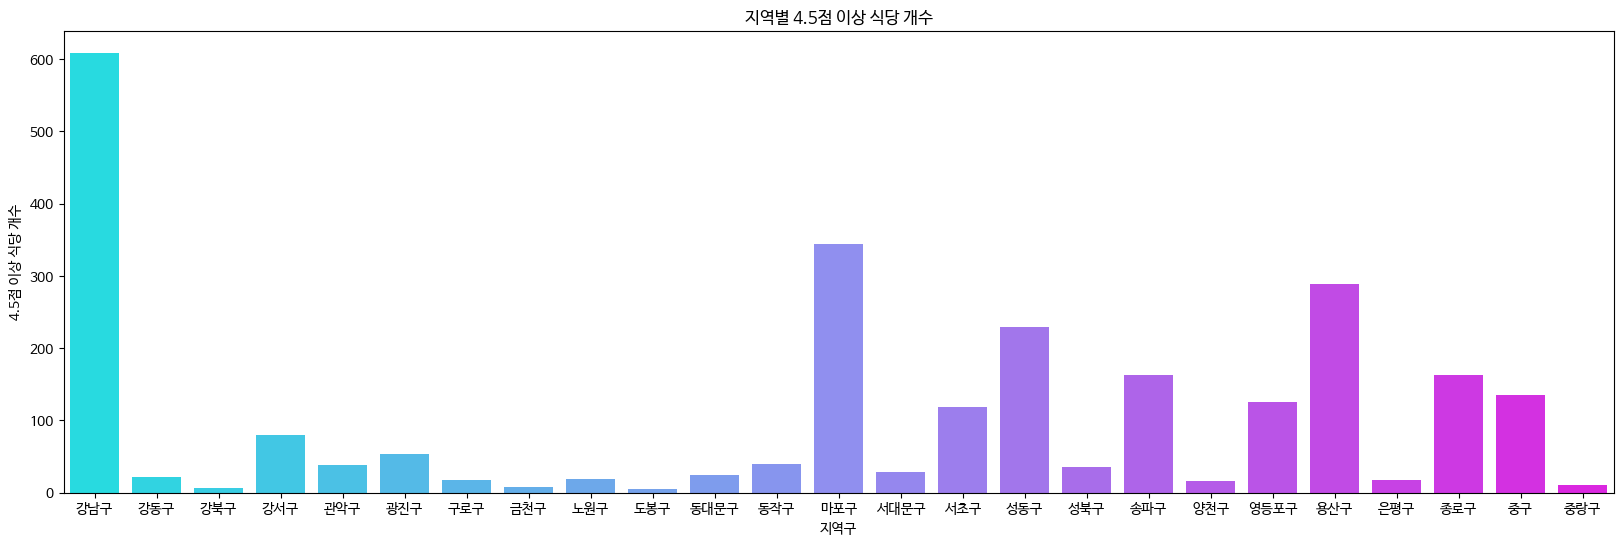

In [30]:
# 지역별 4.5점 이상 식당 개수 계산
rate45_data = s_data[s_data['Rating'] >= 4.5]
rate45_location = rate45_data.groupby('Location_1').size().reset_index(name='4.5점 식당 개수')

print(rate45_location)

# 시각화
plt.figure(figsize=(20, 6))
sns.barplot(data=rate45_location, x='Location_1', y='4.5점 식당 개수', palette='cool')
plt.title('지역별 4.5점 이상 식당 개수')
plt.xlabel('지역구')
plt.ylabel('4.5점 이상 식당 개수')
plt.show()

   Location_1  리뷰 1000개 식당 개수
0         강남구              31
1         강서구               1
2         노원구               1
3         동작구               1
4         마포구              11
5         서초구               5
6         성동구               7
7         성북구               1
8         송파구               8
9        영등포구               6
10        용산구              17
11        종로구               8
12         중구               7


C:\Users\RYS\AppData\Local\Temp\ipykernel_45152\29800898.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=review1000_location, x='Location_1', y='리뷰 1000개 식당 개수', palette='cool')


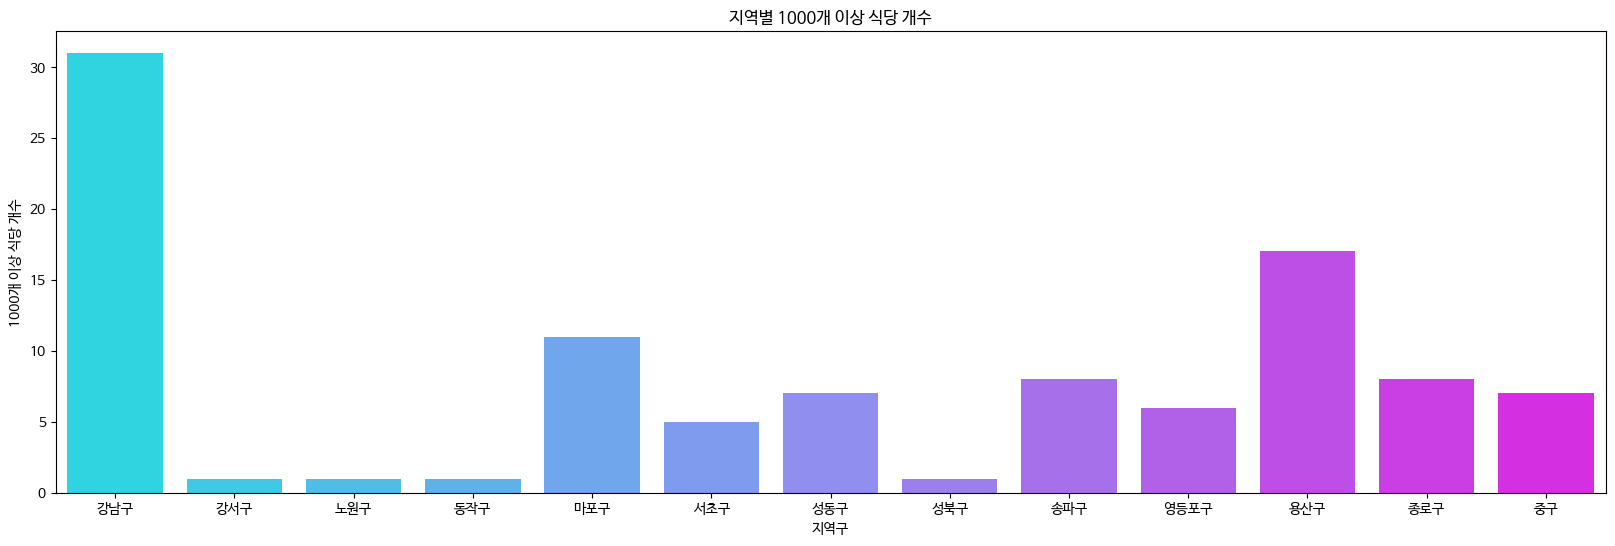

In [34]:
# 지역별 리뷰가 1500 이상 식당 개수 계산
review1000_data = s_data[s_data['Review'] >= 1000]
review1000_location = review1000_data.groupby('Location_1').size().reset_index(name='리뷰 1000개 식당 개수')

print(review1000_location)

# 시각화
plt.figure(figsize=(20, 6))
sns.barplot(data=review1000_location, x='Location_1', y='리뷰 1000개 식당 개수', palette='cool')
plt.title('지역별 1000개 이상 식당 개수')
plt.xlabel('지역구')
plt.ylabel('1000개 이상 식당 개수')
plt.show()

In [ ]:
# 4.5점이상인 음식점이 300개 이상인 구역에서 가장 많은 음식 카테고리 확인

In [15]:
# 지역별 인기 식당 (평점 최대 3개)
popular_by_location = s_data.groupby('Location_1', group_keys=False).apply(lambda x: x.nlargest(3, 'Rating'))
popular_by_location = popular_by_location.reset_index(drop=True)  # 인덱스 초기화
popular_by_location_result = popular_by_location[['Name', 'Location_1', 'Rating']]

print(popular_by_location_result)


                             Name Location_1  Rating
0                          정돈 신사점        강남구     5.0
1                     DOO771 강남본점        강남구     5.0
2                            영동곰탕        강남구     5.0
3                       파르삐떼 디저트바        강동구     5.0
4                        이자카야 키츠네        강동구     5.0
..                            ...        ...     ...
70               김삼보 제주생고기 & 김치찌개         중구     5.0
71                     블랑제리 더 플라자         중구     5.0
72                             교우        중랑구     5.0
73                          하얼빈포차        중랑구     5.0
74  피제리아 디 파올로(PIZZERIA DI PAOLO)        중랑구     5.0

[75 rows x 3 columns]


C:\Users\RYS\AppData\Local\Temp\ipykernel_45152\99240403.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  popular_by_location = s_data.groupby('Location_1', group_keys=False).apply(lambda x: x.nlargest(3, 'Rating'))


In [16]:
# 지역별 인기 식당 (리뷰 수 최대 3개)
popular_by_location = s_data.groupby('Location_1', group_keys=False).apply(lambda x: x.nlargest(3, 'Review'))
popular_by_location = popular_by_location.reset_index(drop=True)  # 인덱스 초기화
popular_by_location_result = popular_by_location[['Name', 'Location_1', 'Review']]

print(popular_by_location_result)

                 Name Location_1  Review
0              이속우화天空        강남구    3553
1       런던 베이글 뮤지엄 도산        강남구    3419
2                플랫나인        강남구    2858
3   더 화이트 (THE WHITE)        강동구     556
4        ENSEMBLE 앙상블        강동구     266
..                ...        ...     ...
70             올디스 타코         중구    1401
71         산청숯불가든 을지로         중구    1122
72              스시히로이        중랑구     586
73           화로상회 중화점        중랑구      55
74             울타리 곱창        중랑구      23

[75 rows x 3 columns]


C:\Users\RYS\AppData\Local\Temp\ipykernel_45152\1142454066.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  popular_by_location = s_data.groupby('Location_1', group_keys=False).apply(lambda x: x.nlargest(3, 'Review'))
